In [1]:
import numpy as np
import pandas as pd
import io
import codecs
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns

%matplotlib inline 
# %matplotlib notebook

In [2]:
doc = codecs.open('d:/temp/jupyter/acoustic/20200204_isp/10_59_37.txt', 'rU')

In [3]:
df = pd.read_csv(doc, sep = '\t')
df = df.iloc[:,:4]

In [4]:
df.head()

,T[sec],X[м/с2],Y[м/с2],Z[м/с2]
0,0.000000,0.238870,-0.290256,0.009408
1,0.000083,0.255275,-0.293033,0.016595
2,0.000167,0.254870,-0.296055,0.008884
3,0.000250,0.268499,-0.293680,0.020389
4,0.000333,0.248289,-0.297721,0.024029


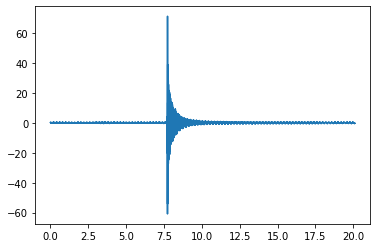

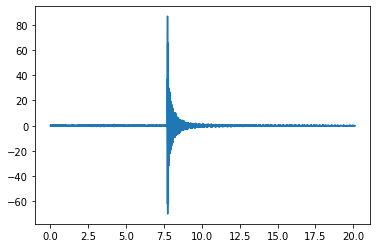

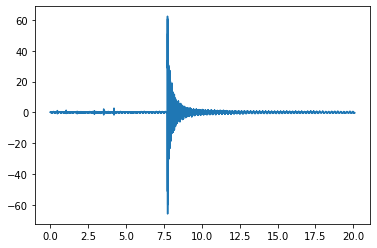

In [5]:
plt.plot(df.iloc[:,0], df.iloc[:,1])
plt.show()
plt.plot(df.iloc[:,0], df.iloc[:,2])
plt.show()
plt.plot(df.iloc[:,0], df.iloc[:,3])
plt.show()

In [6]:
import pywt
import pywt.data

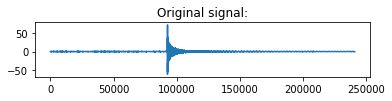

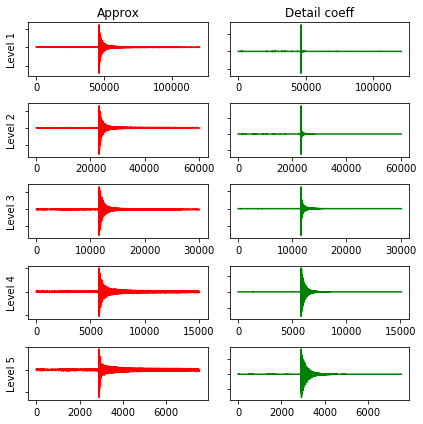

In [7]:
fig, ax = plt.subplots(figsize = (6,1))
ax.set_title('Original signal:')
ax.plot(df.iloc[:,1])
plt.show()

data = df.iloc[:,1]
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data,'r')
    axarr[ii, 1].plot(coeff_d,'g')
    axarr[ii, 0].set_ylabel('Level {}'.format(ii+1), rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii==0:
        axarr[ii, 0].set_title('Approx')
        axarr[ii, 1].set_title('Detail coeff')
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()
    



In [8]:
scales = np.arange(1,500)
cff1, freqs1 = pywt.cwt(data, scales, 'morl')

In [9]:
cff1.shape

(499, 7544)

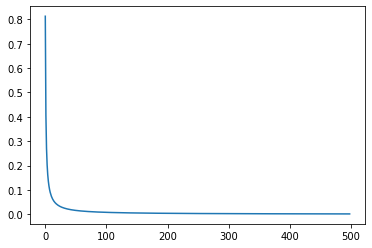

In [10]:
plt.plot(freqs1)

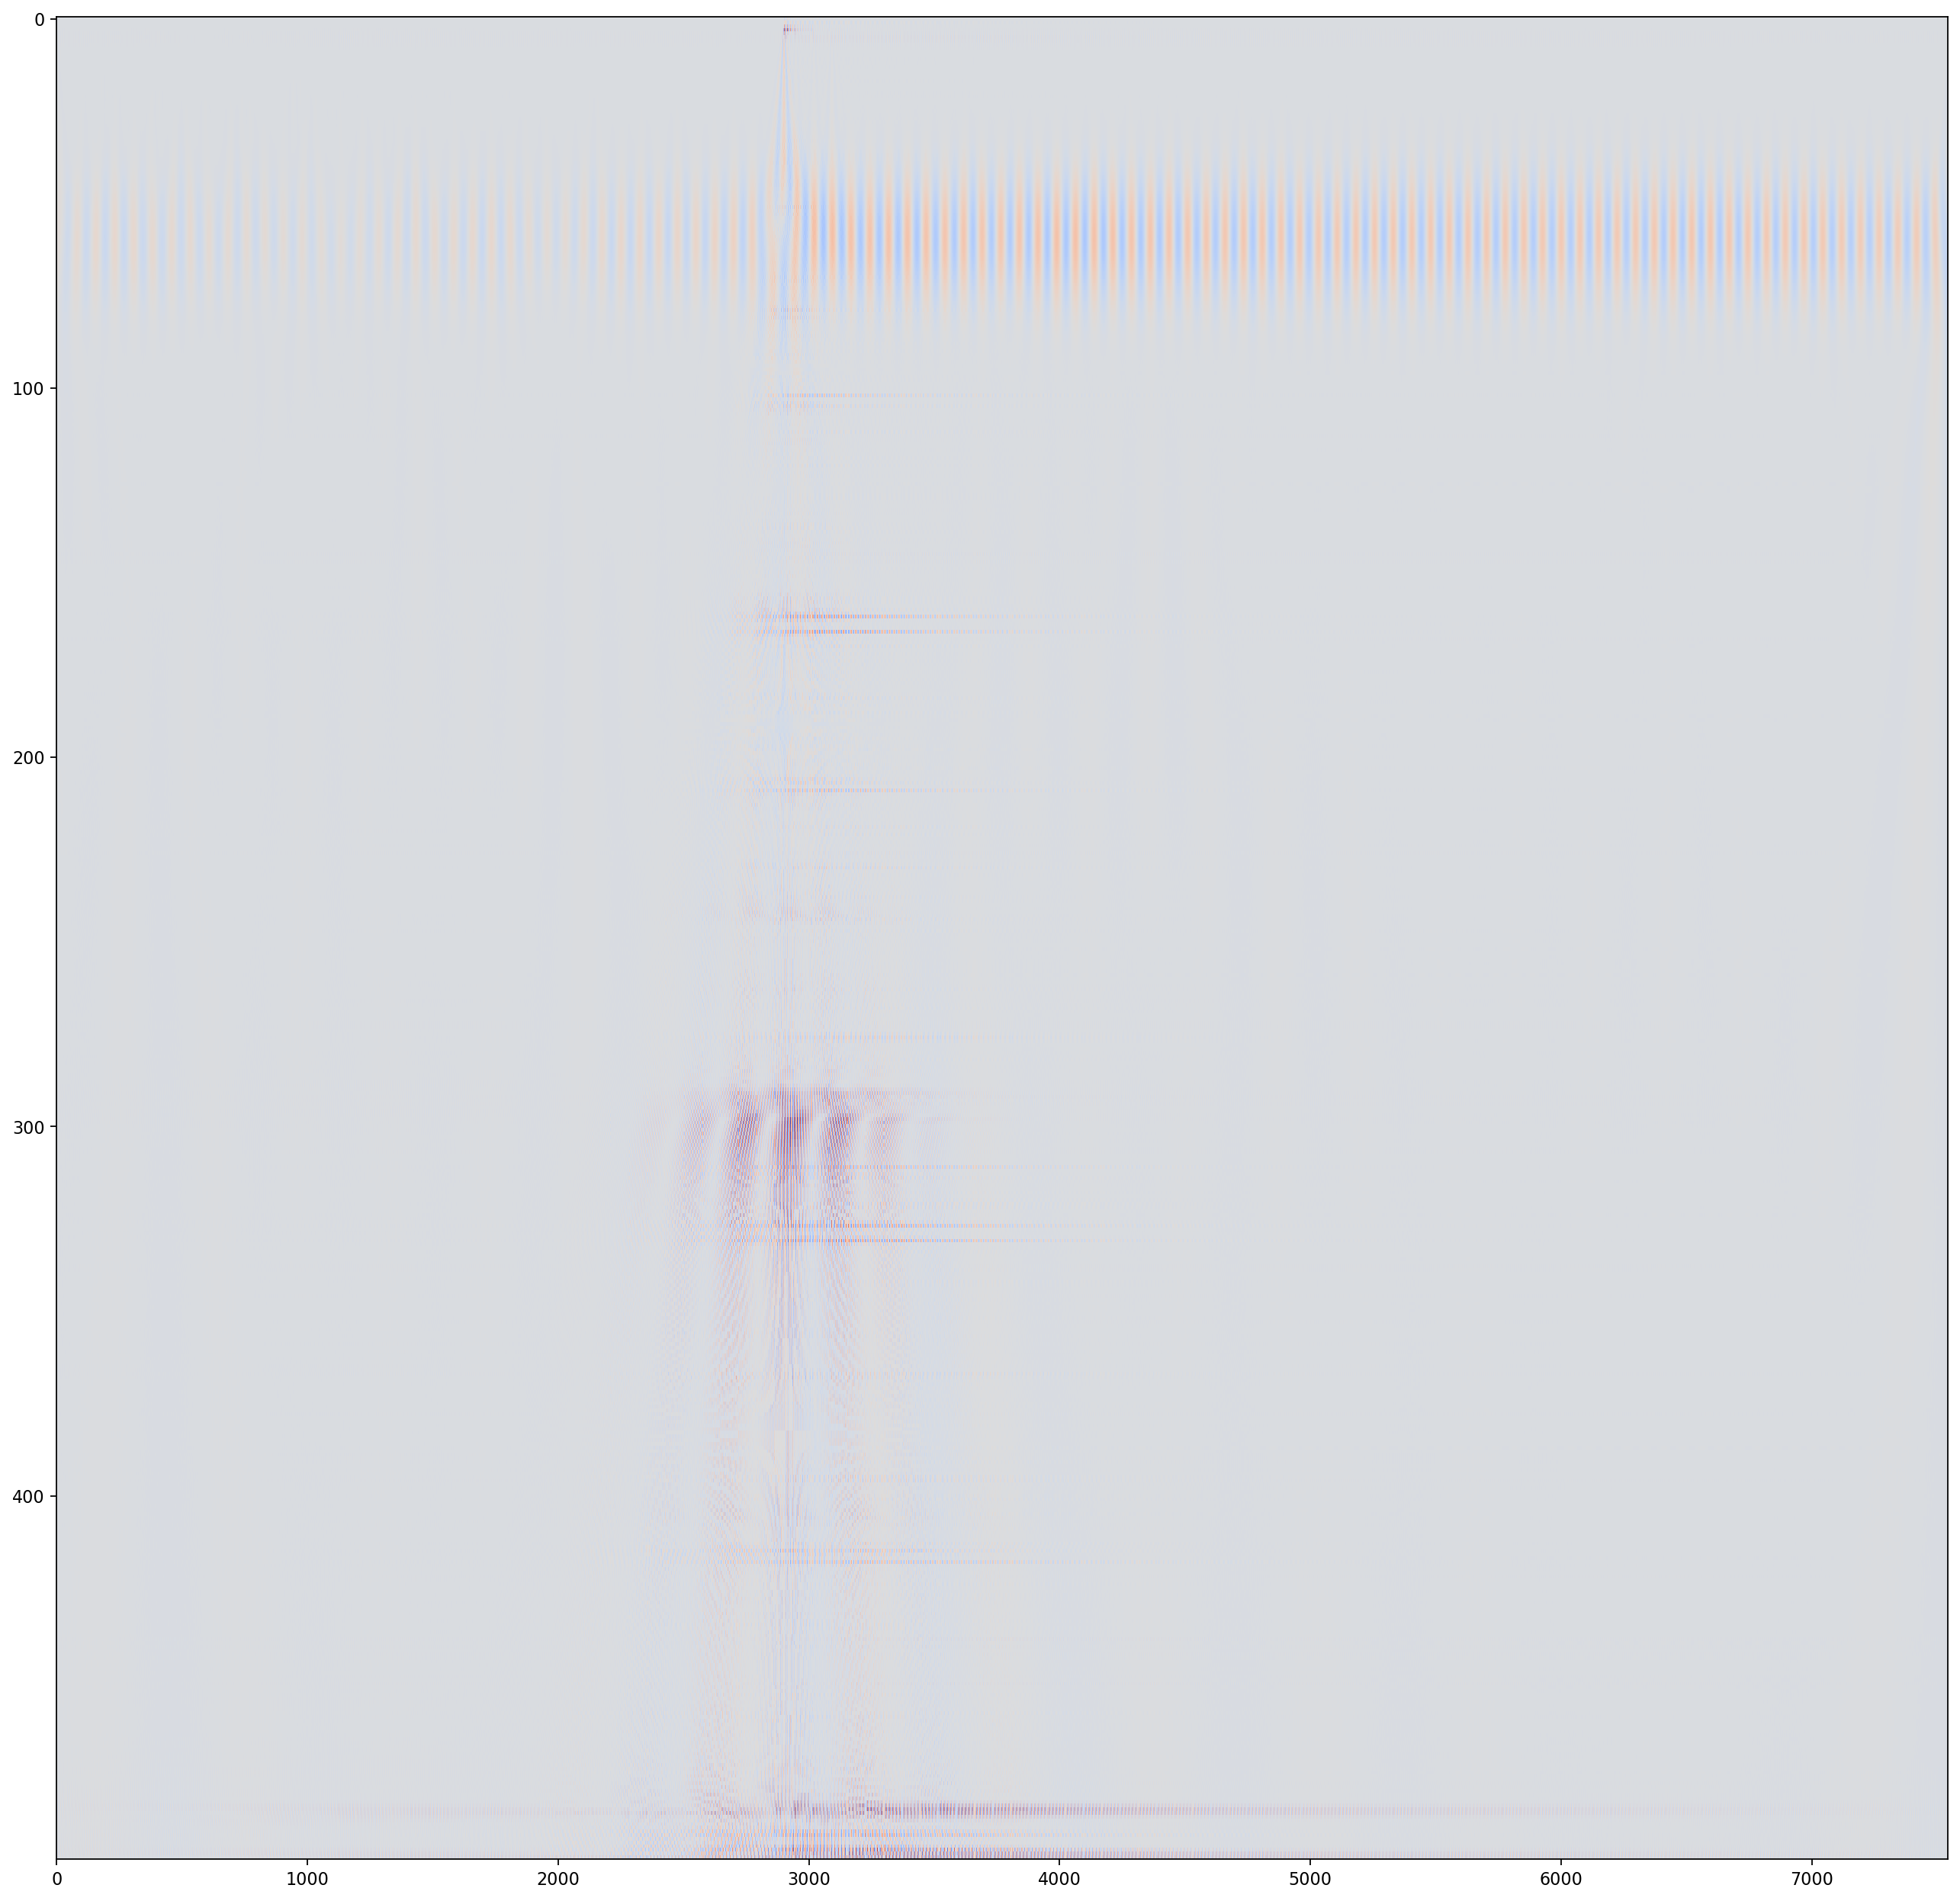

In [11]:
plt.figure(1, figsize=(20, 20), dpi=160)
plt.imshow(cff1, cmap='coolwarm', aspect='auto')
plt.show()

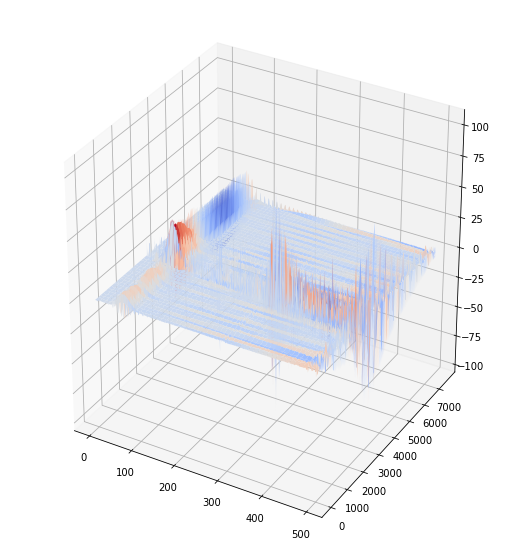

In [12]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 2, 1, projection = '3d')

X = np.arange(0,499,1)
Y = np.arange(0,7544,1)

X,Y = np.meshgrid(X,Y)

ax1.plot_surface(X, Y, np.transpose(cff1), cmap=cm.coolwarm, antialiased=True)

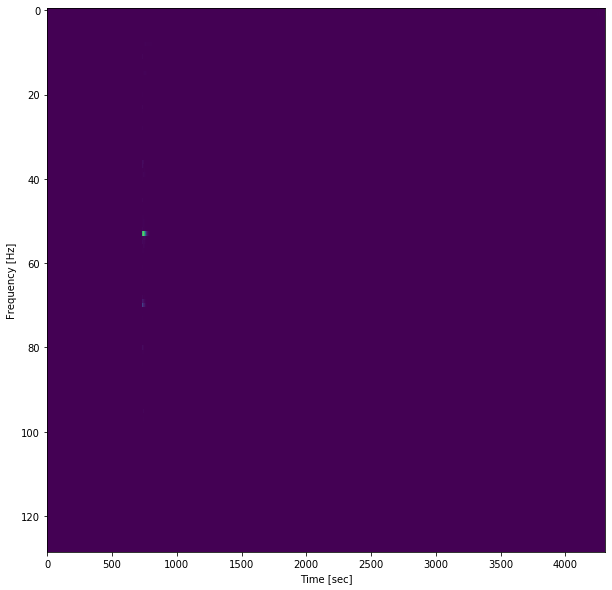

In [63]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('TASCAM_0551S12.wav')

frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate)

plt.figure(1, figsize=(10, 10))
# plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram, aspect='auto' )
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


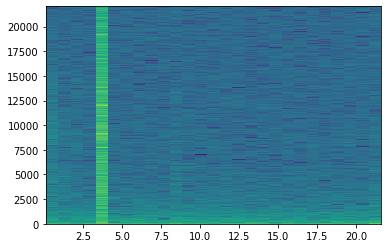

In [153]:
sp, fr, tm, im = plt.specgram(samples, Fs=sample_rate, NFFT=44100, noverlap=9000)

In [154]:
fr[160]

160.0

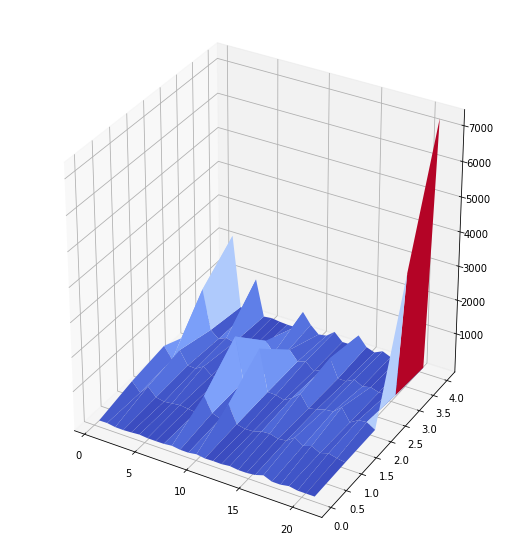

In [155]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 2, 1, projection = '3d')

# X = np.arange(0,499,1)
# Y = np.arange(0,7544,1)

X,Y = np.meshgrid(fr[:5],tm)

ax1.plot_surface(Y, X, np.transpose(sp[:5]), cmap=cm.coolwarm, antialiased=True)


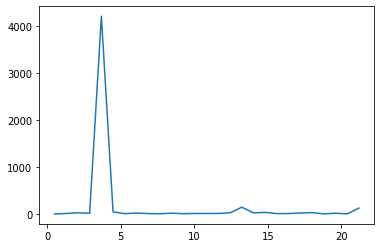

In [156]:
plt.plot(tm, sp[150])

In [157]:
Y.shape

(27, 5)

In [59]:
def spectr(samples, sample_rate, stride_ms = 100.0, window_ms = 150.0, max_freq = 500, eps = 1e-14):
    stride_size = int(0.001*sample_rate*stride_ms)
    window_size = int(0.001*sample_rate*window_ms)
    
    truncate_size = (len(samples)-window_size)%stride_size
    samples = samples[:len(samples)-truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size+1)
    nstrides = (samples.strides[0], samples.strides[0]*stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, shape = nshape, strides=nstrides)
    
    assert np.all(windows[:,1] == samples[stride_size:(stride_size+window_size)])
    
    weighting = np.hanning(window_size)[:, None]
    fft = np.fft.rfft(windows*weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1,:] *= (2.0 / scale)
    
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [60]:
spectr(samples, sample_rate).shape

(76, 218)

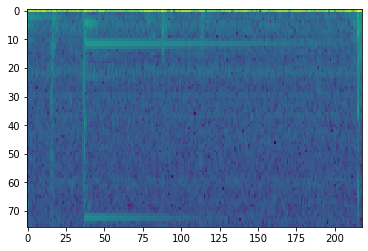

In [61]:
plt.imshow(spectr(samples, sample_rate), aspect='auto' )

Text(0, 0.5, 'Magnitude')

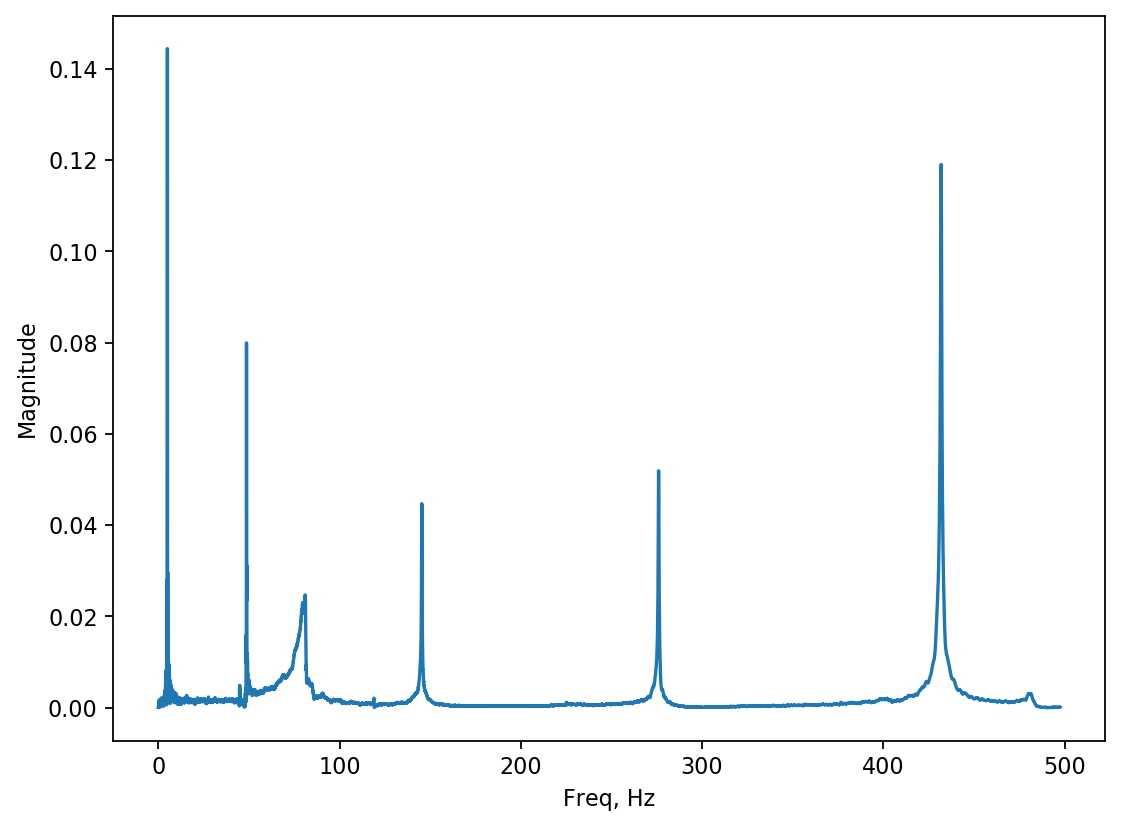

In [17]:
FD = 12000
N = len(df)
DPI = 100
spectrum = rfft(df.iloc[:,1])
spec = rfftfreq(N, 1./FD)

plt.figure(1, figsize=(float(800)/DPI, float(600)/DPI), dpi=160)
plt.plot(spec[:10000], np_abs(spectrum)[:10000]/N)
plt.xlabel('Freq, Hz')
plt.ylabel('Magnitude')

In [23]:
s = pd.DataFrame(spec[:10000],np_abs(spectrum)[:10000]/N).reset_index()
s.columns =['Freq','A']
s.head(20)

,Freq,A
0,0.000089,0.000000
1,0.000160,0.049761
2,0.000137,0.099522
3,0.000450,0.149283
4,0.000235,0.199045
5,0.000181,0.248806
6,0.001367,0.298567
7,0.001087,0.348328
8,0.000738,0.398089
9,0.001508,0.447850


In [22]:
s.to_csv('Spectrum.csv', index=True, float_format='%.7f')